# VGGNet Model transfer learning

## Load dataset

### Train dataset

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = 224
# All images will be rescaled by 1./255 (for data normalization)
# I add new augmented samples using: rotations, zooming, width and height shifts, shearing, etc.
# This doesn't increase the number of original samples but provides varied data during training, helping with generalization.
train_datagen = ImageDataGenerator(
       rescale=1/255,
       rotation_range=10,
       width_shift_range=0.2,
       height_shift_range=0.2,
       shear_range=0.2,
       zoom_range=0.2,
       horizontal_flip=True,
       fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
       './data/train/', 
       target_size=(image_size, image_size),
       batch_size=16,
       class_mode='categorical')


Found 905 images belonging to 5 classes.


### Test dataset

In [2]:
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

test_generator =  test_datagen.flow_from_directory("./data/test/",
                                                        batch_size=16,
                                                        class_mode  = 'categorical',
                                                        target_size = (image_size, image_size))

Found 145 images belonging to 5 classes.


## Create the model

### Load pre-trained VGG model

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load VGG16 model, pre-trained on ImageNet
base_model = VGG16(input_shape=(224, 224, 3),
                   include_top=False,
                   weights='imagenet')

In [4]:
# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

### Add new head to the model

In [ ]:
# add my own FC layers
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation = 'softmax')(x)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
from tensorflow.keras import Model
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
head_model.summary()

## Train the model

### callback functions

In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks_list = [
    ModelCheckpoint(
        filepath='./models/model_vggnet.keras', 
        monitor='val_loss', 
        save_best_only=True),
    EarlyStopping(
        monitor='val_loss', 
        patience=10),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.05, 
        patience=5)
]

### fit the model

In [7]:
history = head_model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=callbacks_list,  
    verbose=1
)

Epoch 1/40


d:\hasan\my projects\weather_classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4456 - loss: 1.4229 - val_accuracy: 0.6483 - val_loss: 1.0665 - learning_rate: 1.0000e-04
Epoch 2/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7723 - loss: 0.6086 - val_accuracy: 0.7724 - val_loss: 0.5956 - learning_rate: 1.0000e-04
Epoch 3/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8278 - loss: 0.4571 - val_accuracy: 0.8138 - val_loss: 0.3876 - learning_rate: 1.0000e-04
Epoch 4/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8899 - loss: 0.3221 - val_accuracy: 0.7724 - val_loss: 0.4771 - learning_rate: 1.0000e-04
Epoch 5/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8938 - loss: 0.2617 - val_accuracy: 0.8897 - val_loss: 0.2823 - learning_rate: 1.0000e-04
Epoch 6/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9170 - loss: 0.2082 - val_accuracy: 0.8000 - val_loss: 0.5208 - learning_rate: 1.0000e-04
Epoch 7/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9207 - loss: 0.1766 - v

## Visualize the loss and accuracy list

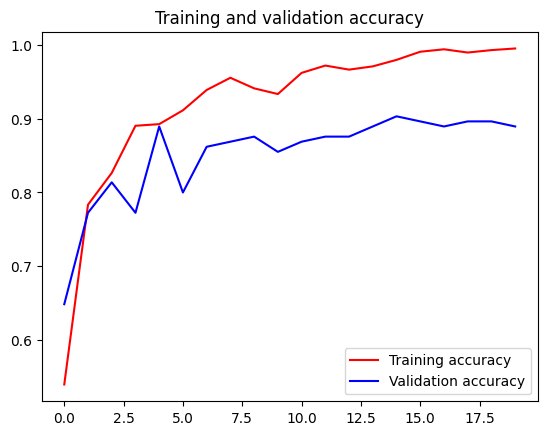

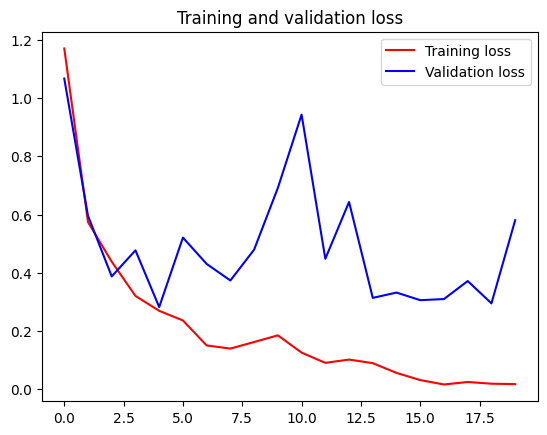

In [8]:
import matplotlib.pyplot as plt
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)